In [ ]:
# TensorFlow version 1.13.1 and keras 2.1.0
!pip install tensorflow==1.13.1
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 92.6 MB 102 kB/s 
     |████████████████████████████████| 3.2 MB 42.2 MB/s 
     |████████████████████████████████| 367 kB 57.6 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.6 requires tensorflow>=2.0.0, but you

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [ ]:
! pip install keras==2.1.0

     |████████████████████████████████| 302 kB 11.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


## Clone the facebook detectron model

In [ ]:
import os
from os.path import exists, join, basename

project_name = "Mask_RCNN"
if not exists(project_name):
  # clone and install
  !git clone -q https://github.com/matterport/Mask_RCNN.git
  !cd $project_name && pip install -q -r requirements.txt
  
import sys
sys.path.append(project_name)

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (560/560), done.


## Import libraries

In [ ]:
# Import Required Libraries
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False


In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath(project_name)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
    
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()


# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)




Using TensorFlow backend.


... done downloading pretrained model!
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


## Load pretrained weights

In [ ]:
# Load the pre-trained weights using the following link 
# https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/e2e_mask _rcnn_X-101-64x4dFPN_1x.yaml.07_50_11.fkwVtEvg/output/train/coco_2014_train%3Acoco_2014_v alminusminival/generalized_rcnn/model_final.pkl
# if the above link doesnt work, use the link in the document at:
#   https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


## Define the classes of the COCO dataset which will help us in the prediction phase

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Use Pre trained weights to generate predictions

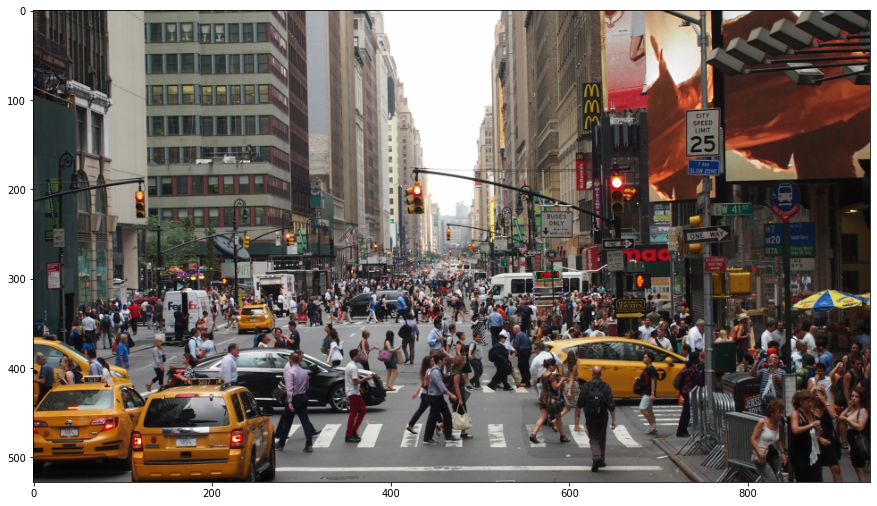

In [ ]:
IMAGE_URL = 'https://i.postimg.cc/vBrLC1BF/pedestrian-road-traffic-street-town-city-546336-pxhere-com.jpg'

image_file = basename(IMAGE_URL)
!wget -q -O $image_file $IMAGE_URL
image = skimage.io.imread(image_file)
plt.figure(figsize=(15, 10))
plt.imshow(image)

Processing 1 images
image                    shape: (528, 937, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


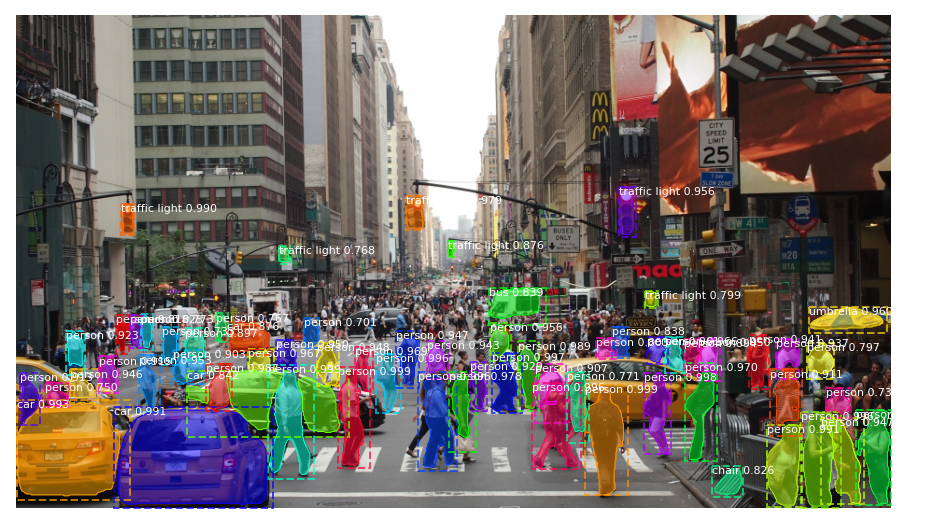

In [ ]:
#t = time.time()
# Run detection
results = model.detect([image], verbose=1)
#print("executed in %.3fs" % (time.time() - t))

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

We can see the multiple specifications of the Mask R-CNN model that we will be using.
So, the backbone is resnet101 as we have discussed earlier as well. The mask shape that will be returned by the model is 28X28, as it is trained on the COCO dataset. And we have a total of 81 classes (including the background).
We can also see various other statistics as well, like:
The input shape
Number of GPUs to be used
Validation steps, among other things.

## Use a picture from the images folder

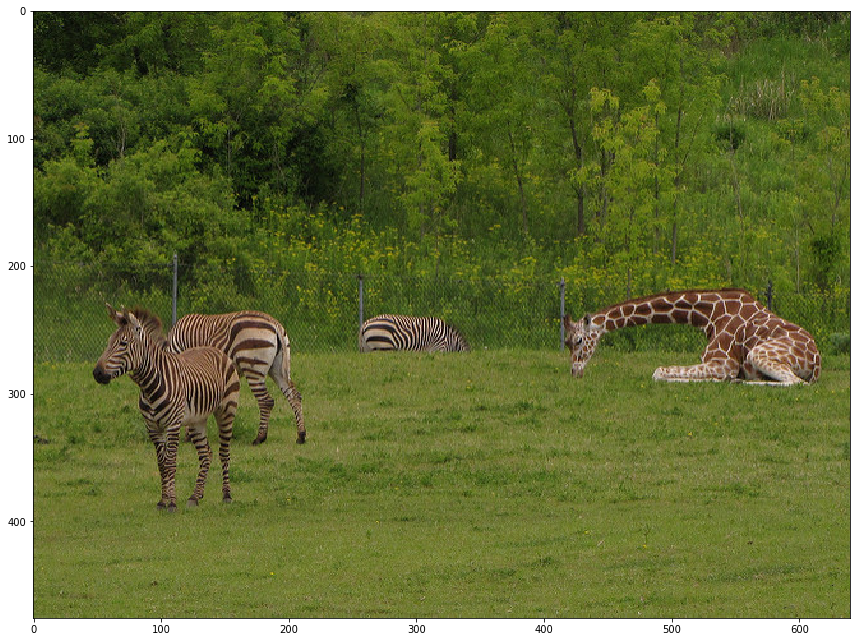

In [ ]:
# Use the Mask RCNN Architecture and the pre-trained weights to generate predictions for your own images 
# or images from the COCO dataset

# Load a random image from the images folder
image = skimage.io.imread('/content/Mask_RCNN/images/3627527276_6fe8cd9bfe_z.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

In [ ]:
# Run detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (476, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  119.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


## Result Visualization

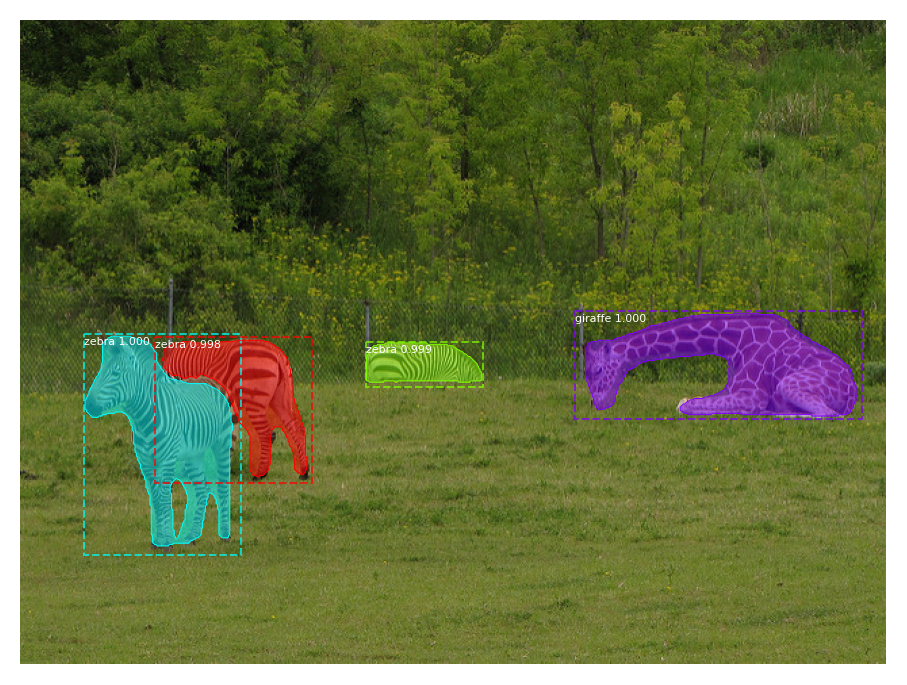

In [ ]:
# Visualize the Results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

## Look at each mask or the segmented objects separately

In [ ]:
#  first take all the masks predicted by our model and store them in the mask variable.
# Now, these masks are in the boolean form (True and False) and hence we need to convert them 
# to numbers (1 and 0)

mask = r['masks']
mask = mask.astype(int)
mask.shape

(476, 640, 4)

## Print or get each segment from the image

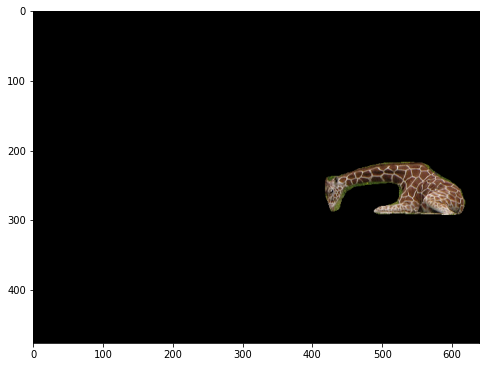

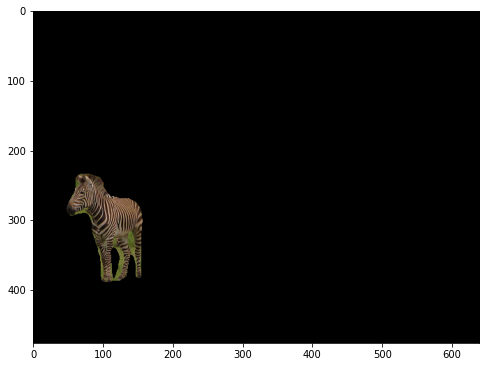

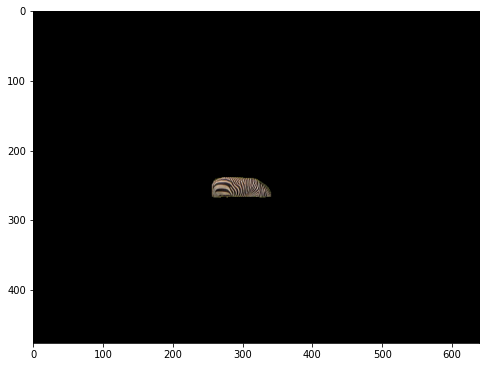

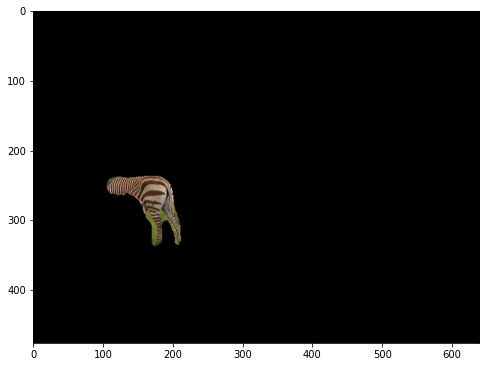

In [ ]:
# To print or get each segment from the image, we will create a for loop and multiply each
#  mask with the original image to get each segment

for i in range(mask.shape[2]):
    temp = skimage.io.imread('/content/Mask_RCNN/images/3627527276_6fe8cd9bfe_z.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)